# EDA & Cleaning Part 2

---

Nate Bukowski

In [254]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

%matplotlib inline

In [228]:
master = pd.read_csv('./master_clean.csv')

In [229]:
master.head()

,date,latitude,longitude,themes,tone
0,2020-01-01,43.0855,129.30200,"['BAN', 'MEDIA_MSM', 'WB_1921_PRIVATE_SECTOR_D...",2.279202
1,2020-01-01,35.0000,105.00000,"['TAX_FNCACT_EXECUTIVE_DIRECTOR', 'WB_566_ENVI...",0.335570
2,2020-01-01,21.0333,105.85000,"['TAX_FNCACT_CHILD', 'TAX_FNCACT_CHILD', 'TAX_...",-4.919786
3,2020-01-01,43.1346,-6.89444,"['RURAL', 'EPU_ECONOMY_HISTORIC', 'AGRICULTURE...",-1.873199
4,2020-01-01,-24.3167,-47.00000,"['MOVEMENT_GENERAL', 'CRISISLEX_T04_INFRASTRUC...",-4.449649


## Vectorizing Themes
---

In [230]:
# Get the 'themes' column ready for the CountVectorizer.

themes_list = [themes.split(',') for themes in master['themes']]

new_theme_list = []
for t_list in themes_list:
    row_themes = [theme.strip('[]') for theme in t_list]
    stripped_themes = []
    for themes in row_themes:
        stripped_themes.append(themes.strip('\' '))
    new_theme_list.append(stripped_themes)
    
string_list = ['_'.join(new_theme_list[i]) for i in range(len(master['themes']))]

spaces_list = [themes.replace('_', ' ') for themes in string_list]

clean_themes = [spaces_list[i].lower() for i in range(len(master['themes']))]

master['themes'] = clean_themes

In [231]:
master.head()

,date,latitude,longitude,themes,tone
0,2020-01-01,43.0855,129.30200,ban media msm wb 1921 private sector developme...,2.279202
1,2020-01-01,35.0000,105.00000,tax fncact executive director wb 566 environme...,0.335570
2,2020-01-01,21.0333,105.85000,tax fncact child tax fncact child tax fncact c...,-4.919786
3,2020-01-01,43.1346,-6.89444,rural epu economy historic agriculture general...,-1.873199
4,2020-01-01,-24.3167,-47.00000,movement general crisislex t04 infrastructure ...,-4.449649


In [232]:
# Count vectorize the 'themes' column.

cvec = CountVectorizer()

cvec.fit(master['themes'])
cvec_themes = cvec.transform(master['themes'])
cvec_themes_df = pd.DataFrame(cvec_themes.toarray(), columns=cvec.get_feature_names())

In [233]:
cvec_themes_df.head()

,1000,1014,1024,1026,1039,1041,1042,1045,1048,1050,...,zambezi,zambian,zealander,zealanders,zika,zimbabwean,zimbabweans,zinc,zones,zoroastrians
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
# Join the count vectorized dataframe with the master dataframe and drop the original 'themes' column.
master = master.join(cvec_themes_df)
master.drop(columns='themes', inplace=True)

In [235]:
master.head()

,date,latitude,longitude,tone,1000,1014,1024,1026,1039,1041,...,zambezi,zambian,zealander,zealanders,zika,zimbabwean,zimbabweans,zinc,zones,zoroastrians
0,2020-01-01,43.0855,129.30200,2.279202,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,35.0000,105.00000,0.335570,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-01,21.0333,105.85000,-4.919786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-01,43.1346,-6.89444,-1.873199,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01,-24.3167,-47.00000,-4.449649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## K-Means Clustering
---

In [268]:
# Adapted from code written by Tim Book (8.01-lesson-intro-to-kmeans)

ss = StandardScaler()
X = ss.fit_transform(master.drop(columns='date'))

scores = []
for k in range(2, 31):
    # Fit model
    km = KMeans(n_clusters=k, random_state=6)
    km.fit(X)
    
    # Get inertia
    inertia = km.inertia_
    
    # Get silhouette
    sil =silhouette_score(X, km.labels_)
    
    # Gather numbers
    scores.append((k, inertia, sil))
    
score_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette'])
score_df.head()

,k,inertia,silhouette
0,2,3.390081e+06,0.349678
1,3,3.373424e+06,0.227950
2,4,3.356418e+06,0.228161
3,5,3.343580e+06,0.228668
4,6,3.315562e+06,0.193715


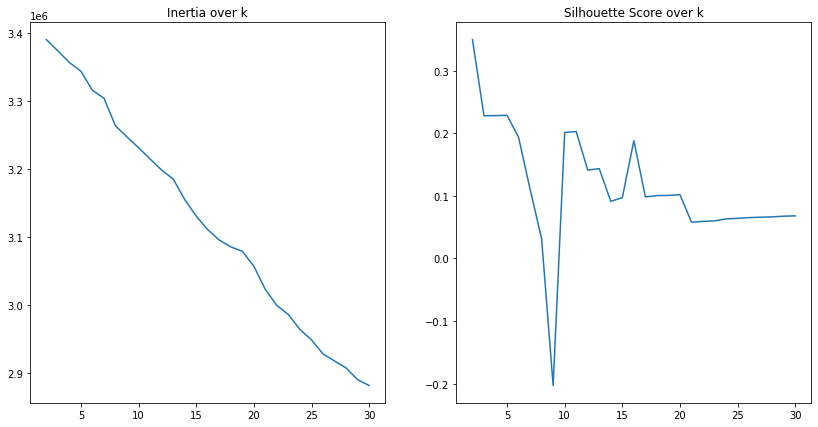

In [269]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k');

In [270]:
# Create 'clusters' column
master['clusters'] = km.labels_

In [271]:
master.to_csv('./cvec_master.csv', index=False)

# Visualizing Latitude, Longitude & Tone

---

In [272]:
# Create a scatterplot between 'latitude' and 'longitude' 

data=go.Scatter(x=master['longitude'],
                y=master['latitude'],
                mode='markers',
                marker_color=master['tone'],
                marker_size=12,
                text=master['tone'])

layout = go.Layout(title='Latitude & Longitude',
                 xaxis=dict(title='Latitude'),
                 yaxis=dict(title='Longitude'))

fig = go.Figure(data=data, layout=layout)
fig.show()

# Visualizing the 6 Core Emotional Dimensions

---

1. **Tone**: This is the average “tone” of the document as a whole. 
2. **Positive Score**: This is the percentage of all words in the article that were found to have a positive emotional connotation.
3. **Negative Score**: This is the percentage of all words in the article that were found to have a positive emotional connotation. 
4. **Polarity**: This is the percentage of words that had matches in the tonal dictionary as an indicator of how emotionally polarized or charged the text is.
5. **Activity Reference Density**: This is the percentage of words that were active words offering a very basic proxy of the overall “activeness” of the text compared with a clinically descriptive text.
6. **Self/Group Reference Density**: This is the percentage of all words in the article that are pronouns, capturing a combination of self-references and group-based discourse.

## Distribution Visualizations
---

*Big thanks to Noelle for the Plotly code skeletons!*

### Tone

In [224]:
# Create a histogram of the 'tone' column.
# data = go.Histogram(x=master['tone'])
# layout = go.Layout(title='Distribution of Tone Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Tone'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [223]:
# Create a boxplot of the 'tone' column.
# data = go.Box(y=master['tone'])
# layout = go.Layout(title='Distribution of Tone Scores Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Tone')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

### Positive Score

In [222]:
# Create a histogram of the 'positive_score' column.
# data = go.Histogram(x=master['positive_score'])
# layout = go.Layout(title='Distribution of Positive Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Positive Score'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [221]:
# Create a boxplot of the 'positive_score' column.
# data = go.Box(y=master['positive_score'])
# layout = go.Layout(title='Distribution of Positive Scores Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Positive Score')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

### Negative Score

In [220]:
# Create a histogram of the 'negative_score' column.
# data = go.Histogram(x=master['negative_score'])
# layout = go.Layout(title='Distribution of Negative Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Negative Score'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [219]:
# Create a boxplot of the 'negative_score' column.
# data = go.Box(y=master['negative_score'])
# layout = go.Layout(title='Distribution of Negative Scores Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Negative Score')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

### Polarity

In [218]:
# Create a hiistogram of the 'polarity' column.
# data = go.Histogram(x=master['polarity'])
# layout = go.Layout(title='Distribution of Polarity Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Polarity'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [217]:
# Create a boxplot of the 'polarity' column.
# data = go.Box(y=master['polarity'])
# layout = go.Layout(title='Distribution of Polarity Scores Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Polarity')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

### Activity Reference Density

In [216]:
# Create a histogram of the 'activity_reference_density' column.
# data = go.Histogram(x=master['activity_reference_density'])
# layout = go.Layout(title='Distribution of Activity Reference Density Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Activity Reference Density'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [215]:
# Create a boxplot of the 'activity_reference_density' column.
# data = go.Box(y=master['activity_reference_density'])
# layout = go.Layout(title='Distribution of Activity Reference Density Scores Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Activity Reference Density')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

### Self/Group Reference Density

In [214]:
# Create a histogram of the 'self_group_reference_density' column.
# data = go.Histogram(x=master['self_group_reference_density'])
# layout = go.Layout(title='Distribution of Self/Group Reference Density Scores Across News Articles Containing the Shortage Theme', 
#                    xaxis=dict(title='Self/Group Reference Density'), 
#                    yaxis=dict(title='Article Count')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

In [213]:
# Create a boxplot of the 'self_group_reference_density' column.
# data = go.Box(y=master['self_group_reference_density'])
# layout = go.Layout(title='Distribution of Self/Group Reference Density Across News Articles Containing the Shortage Theme', 
#                    yaxis=dict(title='Self/Group Reference Density')) 
# fig = go.Figure(data=data, layout=layout) 
# fig.show()

## Relationship Visualizations

---

Tone, Positive Score, Negative Score and Polarity are all dependent calculations. The goal of this section is to viualize how those variables relate to Activity Reference Density and Self/Group Reference Density.

In [212]:
# Create a heatmap to view correlations.
# corr = master[['tone', 'negative_score', 'positive_score','polarity', 
#                'activity_reference_density', 'self_group_reference_density']].corr()

# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# f, ax = plt.subplots(figsize=(10,10))

# sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True,
#             annot=True, linewidths=.5, cmap='coolwarm', cbar_kws={"shrink": .7});

In [48]:
# Create a scatterplot of the relationship between 'tone' and 'activity_reference_density'
# data=go.Scatter(x=master['tone'],
#                 y=master['activity_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['tone'])

# layout = go.Layout(title='Tone vs. Activity Reference Density',
#                  xaxis=dict(title='Tone'),
#                  yaxis=dict(title='Activity Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [49]:
# Create a scatterplot of the relationship between 'tone' and 'activity_reference_density'
# data=go.Scatter(x=master['tone'],
#                 y=master['self_group_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['tone'])

# layout = go.Layout(title='Tone vs. Self/Group Reference Density',
#                  xaxis=dict(title='Tone'),
#                  yaxis=dict(title='Self/Group Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [51]:
# Create a scatterplot of the relationship between 'negative_score' and 'activity_reference_density'
# data=go.Scatter(x=master['negative_score'],
#                 y=master['activity_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['negative_score'])

# layout = go.Layout(title='Negative Score vs. Activity Reference Density',
#                  xaxis=dict(title='Negative Score'),
#                  yaxis=dict(title='Activity Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [52]:
# Create a scatterplot of the relationship between 'negative_score' and 'self_group_reference_density'
# data=go.Scatter(x=master['negative_score'],
#                 y=master['self_group_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['negative_score'])

# layout = go.Layout(title='Negative Score vs. Self/Group Reference Density',
#                  xaxis=dict(title='Negative Score'),
#                  yaxis=dict(title='Self/Group Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [53]:
# Create a scatterplot of the relationship between 'positive_score' and 'activity_reference_density'
# data=go.Scatter(x=master['positive_score'],
#                 y=master['activity_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['positive_score'])

# layout = go.Layout(title='Positive Score vs. Activity Reference Density',
#                  xaxis=dict(title='Positive Score'),
#                  yaxis=dict(title='Activity Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [54]:
# Create a scatterplot of the relationship between 'positive_score' and 'self_group_reference_density'
# data=go.Scatter(x=master['positive_score'],
#                 y=master['self_group_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['positive_score'])

# layout = go.Layout(title='Positive Score vs. Self/Group Reference Density',
#                  xaxis=dict(title='Positive Score'),
#                  yaxis=dict(title='Self/Group Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [55]:
# Create a scatterplot of the relationship between 'polarity' and 'activity_reference_density'
# data=go.Scatter(x=master['polarity'],
#                 y=master['activity_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['polarity'])

# layout = go.Layout(title='Polarity vs. Activity Reference Density',
#                  xaxis=dict(title='Polarity'),
#                  yaxis=dict(title='Activity Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [56]:
# Create a scatterplot of the relationship between 'positive_score' and 'self_group_reference_density'
# data=go.Scatter(x=master['polarity'],
#                 y=master['self_group_reference_density'],
#                 mode='markers',
#                 marker_size=12,
#                 text=master['polarity'])

# layout = go.Layout(title='Polarity vs. Self/Group Reference Density',
#                  xaxis=dict(title='Polarity'),
#                  yaxis=dict(title='Self/Group Reference Density'))

# fig = go.Figure(data=data, layout=layout)
# fig.show()